# CheXNet experiments

Pneumonia Detection on Chest X-Rays with Deep Learning

The data is here https://www.kaggle.com/nih-chest-xrays/data. To get it use kaggle api run this.<br>
`kaggle datasets download -d nih-chest-xrays/data`

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
from sklearn.metrics import roc_auc_score

In [4]:
import cv2
import matplotlib.pyplot as plt

## Split v2

In [5]:
class_name = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
               'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
class_name.sort() 
class_name2id = {n:i for i,n in enumerate(class_name)}
class_name2id

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Consolidation': 2,
 'Edema': 3,
 'Effusion': 4,
 'Emphysema': 5,
 'Fibrosis': 6,
 'Hernia': 7,
 'Infiltration': 8,
 'Mass': 9,
 'Nodule': 10,
 'Pleural_Thickening': 11,
 'Pneumonia': 12,
 'Pneumothorax': 13}

In [6]:
N_CLASSES = len(class_name)
N_CLASSES

14

In [7]:
PATH = Path("/data2/yinterian/ChestXray/")

In [8]:
def labels2onehot(classes):
    z = np.zeros(len(class_name), dtype=int)
    if classes != "No Finding":
        indeces = [class_name2id[c] for c in classes.split("|")]
        for i in indeces: z[i] = 1
    return " ".join([str(i) for i in z])

In [9]:
data = pd.read_csv(PATH/"Data_Entry_2017.csv")

In [10]:
data.head()

,ImageIndex,FindingLabels,Follow-up,PatientID,PatientAge,PatientGender,ViewPosition,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


In [23]:
def split_train_val():
    np.random.seed(3)
    train_val_list = pd.read_csv(PATH/"train_val_list.txt")
    data = pd.read_csv(PATH/"Data_Entry_2017.csv")
    data = data.merge(train_val_list, on="ImageIndex", how="right")
    data["Label"] = data['FindingLabels'].apply(labels2onehot)
    patients = data["PatientID"].unique()
    msk = np.random.rand(len(patients)) < 0.9
    train_patients = patients[msk]
    val_patients = patients[~msk]
    print(len(train_patients), len(val_patients))
    test_df = data[data.PatientID.isin(list(train_patients))].copy()
    val_df = data[data.PatientID.isin(list(val_patients))].copy()
    return test_df.loc[:,["ImageIndex", "Label"]], val_df.loc[:,["ImageIndex", "Label"]]

In [24]:
train_df, val_df = split_train_val()

25155 2853


In [25]:
len(train_df), len(val_df)

(77455, 9069)

In [26]:
train_df.head()

,ImageIndex,Label
0,00000001_000.png,0 1 0 0 0 0 0 0 0 0 0 0 0 0
1,00000001_001.png,0 1 0 0 0 1 0 0 0 0 0 0 0 0
2,00000001_002.png,0 1 0 0 1 0 0 0 0 0 0 0 0 0
3,00000002_000.png,0 0 0 0 0 0 0 0 0 0 0 0 0 0
4,00000004_000.png,0 0 0 0 0 0 0 0 0 1 1 0 0 0


In [27]:
#train_df.to_csv(PATH/"train_df.csv", index=False)
#val_df.to_csv(PATH/"val_df.csv", index=False)

In [17]:
def create_test_labels():
    test_list = pd.read_csv(PATH/"test_list.txt")
    data = pd.read_csv(PATH/"Data_Entry_2017.csv")
    data = data.merge(test_list, on="ImageIndex", how="right")
    data["Label"] = data['FindingLabels'].apply(labels2onehot)
    return data.loc[:,["ImageIndex", "Label"]].copy()

In [19]:
test_df = create_test_labels()
len(test_df)

25596

In [20]:
test_df.head()

,ImageIndex,Label
0,00000003_000.png,0 0 0 0 0 0 0 1 0 0 0 0 0 0
1,00000003_001.png,0 0 0 0 0 0 0 1 0 0 0 0 0 0
2,00000003_002.png,0 0 0 0 0 0 0 1 0 0 0 0 0 0
3,00000003_003.png,0 0 0 0 0 0 0 1 1 0 0 0 0 0
4,00000003_004.png,0 0 0 0 0 0 0 1 0 0 0 0 0 0


In [28]:
#test_df.to_csv(PATH/"test_df.csv", index=False)

In [29]:
test_df.shape

(25596, 2)

## Resize images

In [34]:
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

In [35]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# resize and center crop
def resize_crop_image(path, sz=(250, 250)):
    im = read_image(path)
    im = center_crop(im)
    return cv2.resize(im, sz)

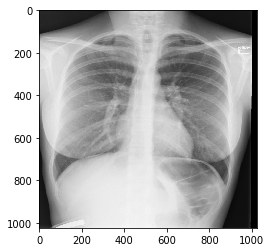

In [36]:
path = PATH/"images/00023354_000.png"
im = read_image(path)
plt.imshow(im)

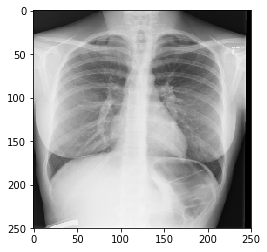

In [37]:
im = resize_crop_image(path)
plt.imshow(im)

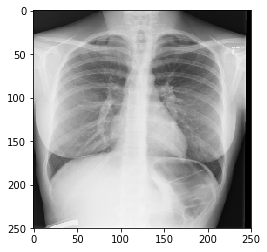

In [38]:
path = PATH/"images_250/00023354_000.png"
im = read_image(path)
plt.imshow(im)

In [39]:
im.shape

(250, 250, 3)

In [20]:
def resize_all_images(resize_path, org_path):
    files = [x for x in list(org_path.iterdir()) if x.suffix == ".png"]
    for f in files:
        f_name = f.parts[-1]    
        new_path = resize_path/f_name
            
        im = resize_crop_image(f)
        cv2.imwrite(str(new_path), cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

In [21]:
# Run this line just once
#resize_all_images(PATH/"images_250", PATH/"images")